# Data modelling

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

## Auxiliary functions

In [3]:
def read_and_split(path='../data/processed/processed_data.csv'):
    '''
    Given the data path, reads it and processes it by separating
    the dataset into negative and positive examples
    '''
    df_full = pd.read_csv(path)
    pos = df_full[df_full.faultInducingBool == 1].copy().reset_index(drop=True)
    neg = df_full[df_full.faultInducingBool == 0].sample(n=1000, random_state=42)
    neg.dropna(inplace=True)
    df_red = pd.concat([neg, pos], axis=0)
    X = df_red.drop(columns=['faultInducingBool']).to_numpy()
    y = df_red.faultInducingBool.to_numpy()
    trX, valX, trY, valY = train_test_split(X, y, test_size=0.25, random_state=42)
    return trX, valX, trY, valY, df_red.drop(columns=['faultInducingBool']).columns

In [4]:
def get_model_metrics(clf, trX, trY, valX, valY, log=True):
    '''
    Displays the model metrics (both training and validation).
    For convenience, returns the validation F1 score
    '''
    tr_preds = clf.predict(trX)
    val_preds = clf.predict(valX)
    if log:
        ConfusionMatrixDisplay(confusion_matrix(trY, tr_preds, normalize='true'), display_labels=['0', '1']).plot()
        print('---------TRAINING-----------')
        plt.title('Training confusion matrix')
        plt.show()
        print('Recall is {}'.format(recall_score(trY, tr_preds)))
        print('Precision is {}'.format(precision_score(trY, tr_preds)))
        print('F1 Score is {}'.format(f1_score(trY, tr_preds)))
        ConfusionMatrixDisplay(confusion_matrix(valY, val_preds, normalize='true'), display_labels=['0', '1']).plot()
        print('---------VALIDATION---------')
        plt.title('Validation confusion matrix')
        plt.show()
        print('Recall is {}'.format(recall_score(valY, val_preds)))
        print('Precision is {}'.format(precision_score(valY, val_preds)))
        print('F1 Score is {}'.format(f1_score(valY, val_preds)))
    return f1_score(valY, val_preds)

## Getting the data

In [5]:
trX, valX, trY, valY, feat_cols = read_and_split()

In [6]:
feat_cols

Index(['inMainBranch', 'maxComplexity', 'meanComplexity', 'totalLinesAdded',
       'totalLinesRemoved', 'totalNloc', 'maxTokenCount', 'meanTokenCount',
       'changedFiles', 'dayOfWeek_0', 'dayOfWeek_1', 'dayOfWeek_2',
       'dayOfWeek_3', 'dayOfWeek_4', 'dayOfWeek_5', 'dayOfWeek_6',
       'committerHourOfDay'],
      dtype='object')

As some machine learning models typically perform better with scaled data, we normalize the data.

In [7]:
scaler = StandardScaler()
trX_sc = scaler.fit_transform(trX)
valX_sc = scaler.transform(valX)

## Models

### Naive Bayes

In [8]:
nb = GaussianNB()
nb.fit(trX, trY)

GaussianNB()

---------TRAINING-----------


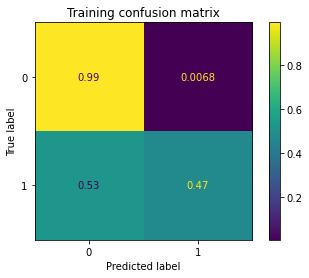

Recall is 0.47346938775510206
Precision is 0.9789029535864979
F1 Score is 0.6382393397524072
---------VALIDATION---------


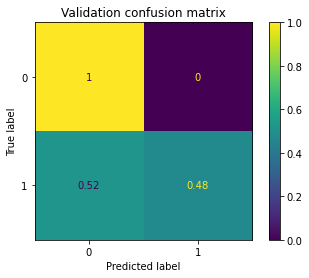

Recall is 0.4782608695652174
Precision is 1.0
F1 Score is 0.6470588235294118


0.6470588235294118

In [9]:
get_model_metrics(nb, trX, trY, valX, valY)

### Support Vector Machine

In [10]:
Cs = [0.1, 1, 10, 100, 1000, 10**5, 10**6]
kernels = ['rbf', 'poly']
degrees = [2, 3]
best_f1 = -1
best_mod_params = None
for c in Cs:
    for kernel in kernels:
        for degree in degrees:
            svm = SVC(C=c, kernel=kernel, degree=degree, random_state=42)
            svm.fit(trX, trY)
            curr_f1 = get_model_metrics(svm, trX, trY, valX, valY, log=False)
            if curr_f1 > best_f1:
                best_f1 = curr_f1
                best_mod_params = {'c': c, 'kernel': kernel, 'degree': degree}
print(best_f1, best_mod_params)

0.7870036101083033 {'c': 1000000, 'kernel': 'rbf', 'degree': 2}


In [11]:
svm = SVC(C=10**6, kernel='rbf', random_state=42)
svm.fit(trX, trY)

SVC(C=1000000, random_state=42)

---------TRAINING-----------


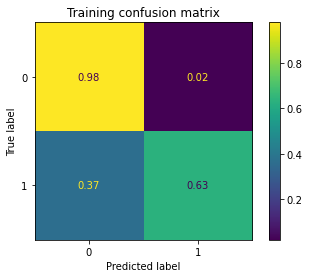

Recall is 0.6326530612244898
Precision is 0.9538461538461539
F1 Score is 0.7607361963190183
---------VALIDATION---------


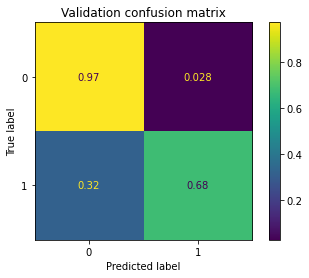

Recall is 0.6770186335403726
Precision is 0.9396551724137931
F1 Score is 0.7870036101083033


0.7870036101083033

In [12]:
get_model_metrics(svm, trX, trY, valX, valY)

### Random Forest

In [13]:
rf = RandomForestClassifier(n_estimators=500, max_depth=8, random_state=42)
rf.fit(trX, trY)

RandomForestClassifier(max_depth=8, n_estimators=500, random_state=42)

---------TRAINING-----------


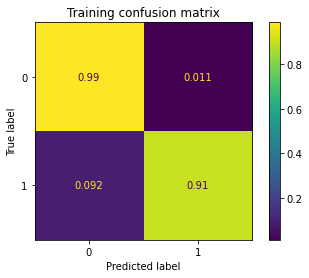

Recall is 0.9081632653061225
Precision is 0.9823399558498896
F1 Score is 0.9437963944856841
---------VALIDATION---------


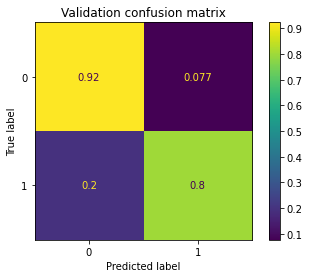

Recall is 0.8012422360248447
Precision is 0.8716216216216216
F1 Score is 0.8349514563106796


0.8349514563106796

In [14]:
get_model_metrics(rf, trX, trY, valX, valY)

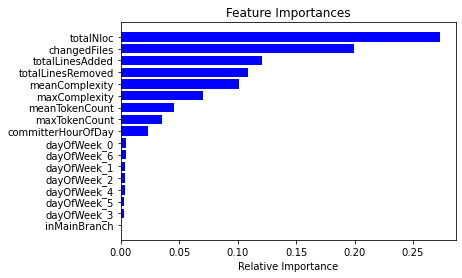

In [15]:
features = feat_cols.tolist()
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [19]:
rf.predict(np.zeros(len(features)).reshape(1, -1))

array([0])

### Gradient boosting

In [41]:
gb = GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42)
gb.fit(trX, trY)

GradientBoostingClassifier(max_depth=5, random_state=42)

---------TRAINING-----------


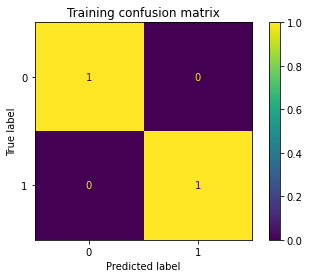

Recall is 1.0
Precision is 1.0
F1 Score is 1.0
---------VALIDATION---------


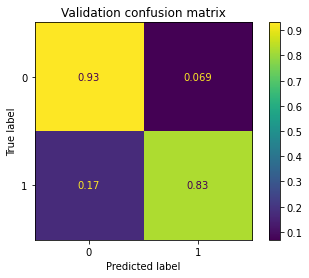

Recall is 0.8260869565217391
Precision is 0.8866666666666667
F1 Score is 0.855305466237942


0.855305466237942

In [42]:
get_model_metrics(gb, trX, trY, valX, valY)

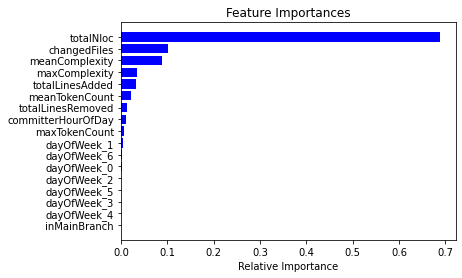

In [38]:
features = feat_cols.tolist()
importances = gb.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

The gradient boosting model performs a bit better on the validation set than the random forest model, which in turn outperform by far both the SVM and the Naive Bayes classifier. However, it is worth noting that the gradient boosting model is heavily biased towards the total number of lines and is extremely overfit, so the final chosen model is random forest as it is more balanced and less biased to the feature totalNloc.